In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nivapy3 as nivapy
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import xarray as xr
from datetime import datetime

# warnings.filterwarnings("ignore")
plt.style.use("ggplot")

# ICPW Thematic Report 2020 - Nitrogen (Part 7: Deposition trends)

The notebook here:

    icpw2/deposition_data/dep_data_proc.ipynb
    
processes total N deposition data for the USA from 1990 to 2016 (as well as European data from Thredds, which we're not using here). For Europe, Max has supplied data here:

    icp_waters/icpw2/deposition_data/csv/europe
    
and for Canada we have data from Julian here:

    icpw2/deposition_data/csv/canada
    
This notebook combines all three datasets and calculates trends.

## 1. Get stations

In [2]:
# Read stations
stn_path = r"../data/all_icpw_sites_may_2020.xlsx"
stn_df = pd.read_excel(stn_path, sheet_name="all_icpw_stns")

# Check stn numbers seem OK
trend_df = stn_df.query("group in ('Trends', 'Trends+Core')")
core_df = stn_df.query("group in ('Core', 'Trends+Core')")

print(f"There are {len(stn_df)} unique stations within the ICPW project as a whole.")
stn_df.head()

There are 556 unique stations within the ICPW project as a whole.


,station_id,station_code,station_name,latitude,longitude,altitude,continent,country,region,group
0,38115,Tr18_CA_DO1,Blue Chalk Lake,45.1999,-78.9432,344.0,North America,Canada,Ont,Trends
1,38116,Tr18_CA_DO2,Chub Lake,45.2138,-78.9836,343.0,North America,Canada,Ont,Trends
2,38117,Tr18_CA_DO3,Crosson Lake,45.0840,-79.0360,371.0,North America,Canada,Ont,Trends
3,38118,Tr18_CA_DO4,Dickie Lake,45.1510,-79.0876,379.0,North America,Canada,Ont,Trends
4,38119,Tr18_CA_DO5,Harp Lake,45.3798,-79.1335,327.0,North America,Canada,Ont,Trends


## 2. Read deposition data

### 2.1. USA

These data are already in $mgN/m^2$.

In [3]:
# Read US data
csv_path = r"../deposition_data/csv/usa/totn_dep_icpw_stns_usa_wide.csv"
us_df = pd.read_csv(csv_path, skiprows=1, index_col=0)
us_df.index.name = "station_id"
us_df.head()

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
station_id,,,,,,,,,,,,,,,,,,,,,
23621,1344.3528,1241.1166,1198.3774,1122.9595,1253.4452,1217.8281,1301.2722,1200.0865,1305.1733,1421.4996,...,1138.2770,1070.57200,843.94890,806.71045,993.60974,820.46216,831.21610,793.99054,754.73883,759.82025
23622,1514.5663,1273.5227,1283.2811,1249.9584,1317.4763,1752.1810,1852.2694,1385.9664,1292.0067,1275.9724,...,1075.8159,956.45560,895.98410,961.35270,1008.10297,906.88880,930.64910,880.59830,889.63196,932.04620
23623,1477.2411,1224.6640,1226.2175,1400.4136,1688.1921,1983.8301,2257.7175,1441.5062,1887.4308,1800.6069,...,1293.9430,1148.45900,871.52985,939.19710,1044.64200,1018.05000,862.67664,982.37590,912.16330,871.42944
23624,1431.7246,1162.3424,1085.6859,1331.7225,1373.7268,2259.2334,1843.8962,1273.0300,1631.6055,1546.7393,...,1168.7420,1029.78200,783.01117,861.88385,1008.36896,923.26520,811.85114,898.60913,858.93620,800.51404
23646,1226.8250,1134.7336,1094.3218,1050.1627,1181.6305,1056.9277,1205.2433,1119.6564,1124.2422,1212.3231,...,917.6225,843.12994,667.75050,636.61487,791.75540,705.01400,716.17850,682.77410,673.14730,653.53430


### 2.2. Canada

These data are in $eq/ha$.

In [4]:
# Read Canadian data
csv_path = r"../deposition_data/csv/canada/icpw_deposition_jes_tidy.csv"
ca_df = pd.read_csv(csv_path, sep=";", index_col=0)

# Convert untis
ca_df = ca_df * 14 * 1000 / 10000  # eq/ha to mgN/m2

ca_df.head()

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
station_id,,,,,,,,,,,,,,,,,,,,,
38115,874.256731,871.800073,869.343414,866.886755,864.430097,865.647125,866.864153,868.081181,869.298209,870.515237,...,700.746644,670.944864,641.143084,632.072015,623.000946,613.929877,604.858808,595.787739,586.716670,577.645601
38116,859.089259,856.705864,854.322469,851.939074,849.555679,850.739582,851.923484,853.107387,854.291290,855.475193,...,688.613429,659.326490,630.039551,621.139386,612.239221,603.339057,594.438892,585.538727,576.638563,567.738398
38117,964.383986,962.056561,959.729136,957.401711,955.074286,956.266854,957.459421,958.651988,959.844555,961.037122,...,773.286697,740.385308,707.483919,697.646600,687.809282,677.971963,668.134645,658.297326,648.460008,638.622689
38118,953.517102,951.156630,948.796159,946.435687,944.075215,945.277578,946.479940,947.682302,948.884664,950.087026,...,764.526652,732.000239,699.473827,689.721185,679.968544,670.215903,660.463262,650.710620,640.957979,631.205338
38119,922.755682,920.120562,917.485441,914.850321,912.215201,913.516276,914.817352,916.118427,917.419502,918.720578,...,739.587129,708.135126,676.683122,667.090216,657.497310,647.904404,638.311497,628.718591,619.125685,609.532778


### 2.3. Europe

These data are already in $mgN/m^2$.

In [5]:
# Read European data
csv_path = r"../deposition_data/csv/europe/NH3_a.csv"
nh3_df = pd.read_csv(csv_path, index_col=0)
nh3_df.index.name = "station_id"
del nh3_df["Lat"], nh3_df["Lon"], nh3_df["2017"]

csv_path = r"../deposition_data/csv/europe/NOx_a.csv"
nox_df = pd.read_csv(csv_path, index_col=0)
nox_df.index.name = "station_id"
del nox_df["Lat"], nox_df["Lon"], nox_df["2017"]

assert nox_df.shape == nh3_df.shape
assert (nox_df.index == nh3_df.index).all()

# Calculate total N
eu_df = nox_df + nh3_df

# Remove two Polish stations with invalid IDs
# ('??' in our original file; -1 and -2 in Max's data)
eu_df = eu_df.query("station_id > 0")

eu_df.head()

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
station_id,,,,,,,,,,,,,,,,,,,,,
38201,2676.50,2583.41,2489.96,2396.17,2302.03,2207.54,2144.15,2080.40,2016.30,1951.85,...,1686.52,1524.16,1540.35,1421.78,1356.20,1402.01,1430.98,1289.05,1329.80,1307.64
38202,2661.92,2569.31,2476.37,2383.11,2289.52,2195.59,2131.97,2068.00,2003.68,1939.00,...,1662.25,1507.05,1515.30,1404.35,1345.01,1389.43,1418.12,1265.80,1313.54,1289.22
38203,2072.95,2000.22,1927.57,1854.98,1782.48,1710.06,1658.36,1606.51,1554.53,1502.42,...,1290.06,1236.44,1248.59,1183.64,1098.80,1166.23,1148.44,1093.98,1106.41,1104.98
38204,2310.40,2228.93,2147.34,2065.65,1983.86,1901.97,1844.74,1787.30,1729.61,1671.69,...,1421.62,1286.30,1300.31,1233.04,1141.69,1235.83,1266.35,1107.94,1158.49,1145.21
38205,2410.87,2326.08,2241.11,2155.97,2070.68,1985.21,1925.84,1866.20,1806.29,1746.12,...,1471.35,1353.43,1353.49,1279.81,1205.66,1278.89,1313.67,1140.38,1198.97,1181.47


### 2.4. Combine all data

In [11]:
dep_df = pd.concat([us_df, ca_df, eu_df])

print(len(dep_df), "station in total.")

# Save
dep_df.to_csv(r'../deposition_data/csv/icpw_totn_dep_1990-2016_all_stns.csv')

dep_df.head()

556 station in total.


,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
station_id,,,,,,,,,,,,,,,,,,,,,
23621,1344.3528,1241.1166,1198.3774,1122.9595,1253.4452,1217.8281,1301.2722,1200.0865,1305.1733,1421.4996,...,1138.2770,1070.57200,843.94890,806.71045,993.60974,820.46216,831.21610,793.99054,754.73883,759.82025
23622,1514.5663,1273.5227,1283.2811,1249.9584,1317.4763,1752.1810,1852.2694,1385.9664,1292.0067,1275.9724,...,1075.8159,956.45560,895.98410,961.35270,1008.10297,906.88880,930.64910,880.59830,889.63196,932.04620
23623,1477.2411,1224.6640,1226.2175,1400.4136,1688.1921,1983.8301,2257.7175,1441.5062,1887.4308,1800.6069,...,1293.9430,1148.45900,871.52985,939.19710,1044.64200,1018.05000,862.67664,982.37590,912.16330,871.42944
23624,1431.7246,1162.3424,1085.6859,1331.7225,1373.7268,2259.2334,1843.8962,1273.0300,1631.6055,1546.7393,...,1168.7420,1029.78200,783.01117,861.88385,1008.36896,923.26520,811.85114,898.60913,858.93620,800.51404
23646,1226.8250,1134.7336,1094.3218,1050.1627,1181.6305,1056.9277,1205.2433,1119.6564,1124.2422,1212.3231,...,917.6225,843.12994,667.75050,636.61487,791.75540,705.01400,716.17850,682.77410,673.14730,653.53430


## 3. Plots by region

In [7]:
# Melt to long
df = dep_df.reset_index()
df = df.melt(id_vars="station_id")

# Join regions
df = pd.merge(df, stn_df[["station_id", "continent"]], how="left", on="station_id")

df.rename({"variable": "year", "value": "totn_mgNpm2"}, inplace=True, axis=1)

df['year'] = df['year'].astype(int)

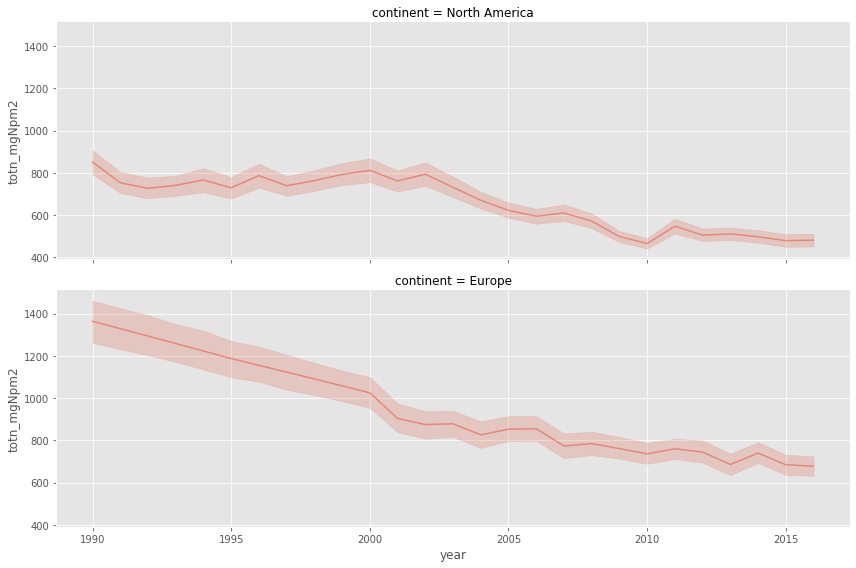

In [8]:
sn.relplot(
    data=df,
    x="year",
    y="totn_mgNpm2",
    row="continent",
    height=4,
    aspect=3,
    kind="line",
    legend=False,
    alpha=0.5,
)

## 4. Trends by station

In [9]:
df.head()

,station_id,year,totn_mgNpm2,continent
0,23621,1990,1344.3528,North America
1,23622,1990,1514.5663,North America
2,23623,1990,1477.2411,North America
3,23624,1990,1431.7246,North America
4,23646,1990,1226.8250,North America


In [10]:
# Dict for results
res_dict = {
    "station_id": [],
    "variable": [],
    "median": [],
    "mk_p_val": [],
    "mk_trend": [],
    "sen_slp": [],
    "sen_incpt": [],
    "sen_trend": [],
}

for stn_id in df['station_id'].unique():
    # Setup plot
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

    df2 = df.query("station_id == @stn_id")
    df2.set_index("year", inplace=True)
    df2.sort_index(inplace=True)

    # MK test
    mk_df = nivapy.stats.mk_test(df2, 'totn_mgNpm2')

    # Sen's slope
    res_df, sen_df = nivapy.stats.sens_slope(
        df2, value_col='totn_mgNpm2', index_col=df2.index
    )

    # Add results to dict
    res_dict["station_id"].append(stn_id)
    res_dict["variable"].append('totn_mgNpm2')
    res_dict["median"].append(df2['totn_mgNpm2'].median())
    res_dict["mk_p_val"].append(mk_df.loc["p"].value)
    res_dict["mk_trend"].append(mk_df.loc["trend"].value)

    sslp = res_df.loc["sslp"].value
    sincpt = res_df.loc["icpt"].value
    res_dict["sen_slp"].append(sslp)
    res_dict["sen_incpt"].append(sincpt)
    res_dict["sen_trend"].append(res_df.loc["trend"].value)

    # Plot
    axes.plot(sen_df.index, sen_df['totn_mgNpm2'].values, "bo-")
    axes.plot(sen_df.index, sen_df.index * sslp + sincpt, "k-")

    axes.set_title('Deposition of TotN (mgN/m2)')
    axes.set_xlim((1990, 2016))

    # Save plot
    plt.tight_layout()
    png_path = f"./results/deposition/stn_{stn_id}_totn_dep_trends.png"
    plt.savefig(png_path, dpi=200)
    plt.close()
        
# Combine results
res_df = pd.DataFrame(res_dict)

# Save
csv_path = f"./results/deposition/totn_dep_trends_icpw_stns.csv"
res_df.to_csv(csv_path, index=False)

res_df.head()

,station_id,variable,median,mk_p_val,mk_trend,sen_slp,sen_incpt,sen_trend
0,23621,totn_mgNpm2,1198.3774,1.481575e-04,decreasing,-22.310291,45885.890883,decreasing
1,23622,totn_mgNpm2,1234.6260,2.923084e-07,decreasing,-24.021200,49349.089600,decreasing
2,23623,totn_mgNpm2,1303.9460,2.541574e-05,decreasing,-38.424610,78268.439830,decreasing
3,23624,totn_mgNpm2,1208.6830,1.751163e-05,decreasing,-34.825050,70963.258150,decreasing
4,23646,totn_mgNpm2,1056.9277,2.541574e-05,decreasing,-24.004373,49137.686273,decreasing
